In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from kan.utils import create_dataset
from adaptkan.jax.model import AdaptKANJax
from adaptkan.jax.viz import plot_model
from adaptkan.jax.fit import fit
from adaptkan.jax.data import DataLoader
from adaptkan.jax.losses import mse_loss_with_reg, mse_loss
import jax.numpy as jnp
import equinox as eqx
import jax
import jax.random as jr
import optax
import time
import matplotlib.pyplot as plt
import torch
import numpy as np
from jax import lax

In [3]:
# Uncomment to use cpu only
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

### Generate our Data

In [4]:
# Generate data to train on
torch.set_default_dtype(torch.float64)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device="cpu", train_num=1000, ranges=[-1.,1.])
dataset['train_input'].shape, dataset['train_label'].shape

X_train = jnp.array(dataset['train_input'])
y_train = jnp.array(dataset['train_label'])
X_test = jnp.array(dataset['test_input'])
y_test = jnp.array(dataset['test_label'])

### Define our model

In [5]:
model, state = eqx.nn.make_with_state(AdaptKANJax)(width=[2,5,1],
                                                   num_grid_intervals=5, # Define the number of grid intervals for the splines
                                                   prune_patience=1, # Should be set to the number of batches per epoch. Influences when the network adapts
                                                   k=5, # Degree of the b-splines (Can be 1-5)
                                                   seed=0,
                                                   basis_type='chebyshev') # Random seed for reproducability

### Define a custom loss function

In [6]:
def basic_mse_loss(model, state, xs, ys, loss_args=None):
    # Forward pass to get predictions
    pred_ys, state = model(xs, state)
    
    # Compute loss
    loss = jnp.mean((pred_ys.squeeze() - ys.squeeze()) ** 2) # + sum(jnp.sum(jnp.square(param)) for param in jax.tree_util.tree_leaves(model)) * 0.00001
        
    # Return loss and a dictionary of metrics here, along with the state
    return loss, ({"loss": loss}, state)

### Training Step for AdaptKAN

In [7]:
@eqx.filter_jit
def make_step(model, state, loss_fn, opt_state, xs, ys):
    
    (loss, (metrics, state)), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model, state, xs, ys)

    # NOTE: this is the only thing that needs to be added for the training compared to a regular MLP
    if isinstance(model, AdaptKANJax):
        # Adapts the domain of the model if needed
        model, state, adapted = model.adapt(state)
        
    updates, opt_state = optim.update(grads, opt_state, params=eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return model, state, opt_state, metrics

### Training Loop

In [8]:
# Define an optimizer
learning_rate = 1.0
optim = optax.adam(learning_rate)

# Initialize the optimizer state
opt_state = optim.init(eqx.filter(model, eqx.is_array))

start = time.time()
for step in range(2000):
    model, state, opt_state, metrics = make_step(model=model,
                                                  state=state,
                                                  opt_state=opt_state,
                                                  loss_fn=basic_mse_loss,
                                                  xs=X_train,
                                                  ys=y_train)
    if (step+1) % 100 == 0:
        print(f"Step {step + 1}, Loss: {metrics['loss'].item()}")
print(f"Took {time.time() - start} seconds.")

Step 100, Loss: 0.20026563107967377
Step 200, Loss: 0.05680712312459946
Step 300, Loss: 0.01358362752944231
Step 400, Loss: 0.004796409513801336
Step 500, Loss: 0.002627474023029208
Step 600, Loss: 0.0015001811552792788
Step 700, Loss: 0.0008153896778821945
Step 800, Loss: 0.0004440270713530481
Step 900, Loss: 0.00024822907289490104
Step 1000, Loss: 0.00014611647929996252
Step 1100, Loss: 9.390607010573149e-05
Step 1200, Loss: 6.735977513017133e-05
Step 1300, Loss: 5.368480196921155e-05
Step 1400, Loss: 4.641605482902378e-05
Step 1500, Loss: 4.240199996274896e-05
Step 1600, Loss: 4.011780038126744e-05
Step 1700, Loss: 3.880309304804541e-05
Step 1800, Loss: 3.805185406235978e-05
Step 1900, Loss: 3.7631518353009596e-05
Step 2000, Loss: 3.7403056921903044e-05
Took 4.238212823867798 seconds.


## Training with Pruning

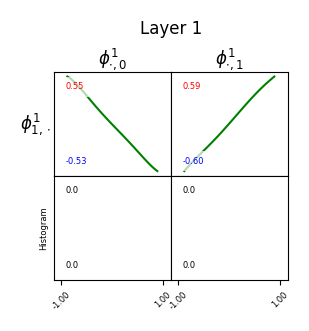

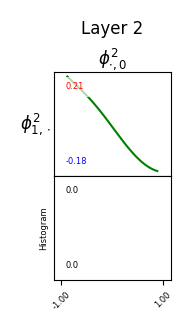

In [16]:
model, state = eqx.nn.make_with_state(AdaptKANJax)(width=[2,1,1],
                                                   num_grid_intervals=5, # Define the number of grid intervals for the splines
                                                   prune_patience=1, # Should be set to the number of batches per epoch. Influences when the network adapts
                                                   k=5, # Degree of the b-splines (Can be 1-5)
                                                   seed=0,
                                                   stretch_mode='max',
                                                   basis_type='chebyshev'
                                                   ) # Random seed for reproducability

plot_model(model, state)

 train_loss: 0.00028664 | test_loss: 0.00033234 |: 100%|███████| 1000/1000 [00:05<00:00, 195.70it/s]


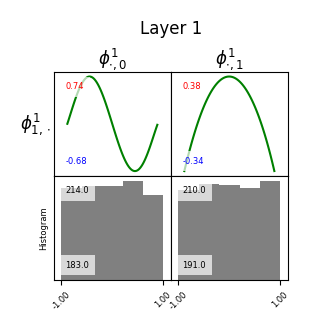

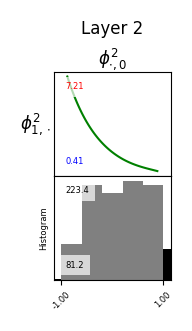

In [17]:
model, state, results = fit(model,
                                state,
                                train_data={"X": X_train, "y": y_train}, # the pre-defined MSE loss requires X and y keys
                                test_data={"X": X_test, "y": y_test},
                                learning_rate=0.1,
                                steps=1000,
                                loss_fn=mse_loss,
                                opt="Adam")

plot_model(model, state)

In [11]:
results['adapted_epochs']

[]

## Prune the weights and edges of the model

In [12]:
# Prune and train twice...
for _ in range(2):
    model, state, results = fit(model,
                                state,
                                train_data={"X": X_train, "y": y_train}, # the pre-defined MSE loss requires X and y keys
                                test_data={"X": X_test, "y": y_test},
                                learning_rate=0.1,
                                steps=1000,
                                loss_fn=mse_loss_with_reg,
                                opt="Adam",
                                # Pruning args
                                loss_args={"lamb": 0.01,
                                          "lamb_l1": 1.0,
                                          "lamb_entropy": 2.0})
    
    model, state = model.prune(X_train, state)
plot_model(model, state)

Training:   0%|                                                            | 0/1000 [00:00<?, ?it/s]


TypeError: mul got incompatible shapes for broadcasting: (16,), (2,).

## Refine the domain grid and continue training

 train_loss: 0.00000010 | test_loss: 0.00000013 |: 100%|███████| 1000/1000 [00:08<00:00, 115.61it/s]


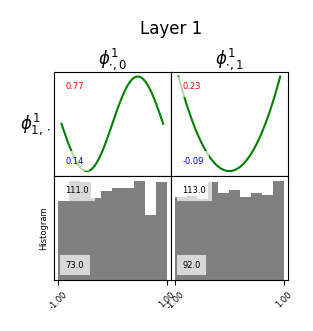

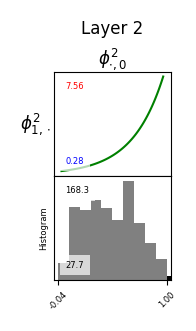

In [ ]:
# This refines the domain grid to a larger number of intervals
model, state = model.refine(state, new_num_grid_intervals=10)

model, state, results = fit(model,
                            state,
                            train_data={"X": X_train, "y": y_train}, # the pre-defined MSE loss requires X and y keys
                            test_data={"X": X_test, "y": y_test},
                            learning_rate=0.01,
                            steps=1000,
                            loss_fn=mse_loss,
                            opt="Adam")
plot_model(model, state)

### Compare with an MLP

In [12]:
model = eqx.nn.MLP(
                   in_size=2,                    # Input feature size
                   out_size=1,                   # Output feature size
                   width_size=100,               # Hidden layer width
                   depth=2,                      # Number of hidden layers
                   activation=jax.nn.tanh,       # Activation function
                   key=jax.random.PRNGKey(42)    # PRNG key for initialization
                  )
state = None # The MLP is stateless

# Fit expects a dataloader or a dictionary with keys to interact with our loss function
model, state, results = fit(model,
                            state,
                            train_data={"X": X_train, "y": y_train}, # the pre-defined MSE loss requires X and y keys
                            test_data={"X": X_test, "y": y_test},
                            learning_rate=.01,
                            steps=3000,
                            opt="Adam")

 train_loss: 0.00044158 | test_loss: 0.00068401 |: 100%|███████| 3000/3000 [00:11<00:00, 272.66it/s]
